In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import h5py
import copy
import datetime
import ta
import yfinance as yf
import tensorflow as tf
import tensorflow.compat.v2.feature_column as fc
from IPython.display import clear_output
import pyodbc
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.exceptions import ConvergenceWarning 
from sklearn import ensemble
# ConvergenceWarning('ignore')
# Do you wanna see?
verbose = True

import sys
sys.path.append('../')

from utils.data_extraction import load_data
from utils.data_cleaning import HFDataCleaning
from utils.generate_features import candleCreateNP_vect_final,\
                                    generateFeatures_final
from utils.preprocessing_features_and_labels import extract_labels,\
                                                    align_features_and_labels,\
                                                    pre_processing_initial,\
                                                    pre_processing_extended,\
                                                    pre_processing
from utils.models import make_input_fn
from utils.models import performanceTesting

### Load data etc

In [2]:
stockInfo = pd.read_csv('../utils/stockInfo.csv',header=[0,1])

In [3]:
# How many are there contained in the file?
print('There is',
      stockInfo.shape[0],
      'tickers contained in the file, and there is data on',
      stockInfo.isnull().sum()[1:].min(),'of them.')

There is 8850 tickers contained in the file, and there is data on 5306 of them.


## Sneak peak on the 10 largest companies

In [4]:

stockInfo.sort_values(('2020-07-05','marketCap'),ascending=False).head(10)

date              2020-07-05                       
     ticker                  sector exchange     marketCap
12     AAPL              Technology      NMS  1.578173e+12
5272   MSFT              Technology      NMS  1.564160e+12
3462   GOOG  Communication Services      NMS  1.001645e+12
2733     FB  Communication Services      NMS  6.650369e+11
699    BABA       Consumer Cyclical      NYQ  5.936536e+11
8228      V      Financial Services      NYQ  4.298068e+11
4459    JNJ              Healthcare      NYQ  3.716463e+11
8583    WMT      Consumer Defensive      NYQ  3.375968e+11
4930     MA      Financial Services      NYQ  3.035511e+11
7950    TSM              Technology      NYQ  2.837483e+11

## How is the tickers divided in sectors?

In [5]:
stockInfo.loc[:,('2020-07-05')].groupby(['sector']).count()#rename(None,axis=1)

,exchange,marketCap
sector,,
Basic Materials,137,137
Communication Services,146,146
Consumer Cyclical,318,317
Consumer Defensive,130,130
Energy,204,204
Financial,3,3
Financial Services,942,942
Healthcare,607,607
Industrials,404,404


## Lets get the X largest companies in each sector.

In [6]:
sectors = stockInfo.loc[:,('2020-07-05')].dropna(axis=0).sector.unique()

X = 5

topXsectors = pd.DataFrame(index = np.arange(X),columns = pd.MultiIndex.from_product([['Top {}'.format(X)],sectors]))

t1 = pd.DataFrame({'tickers':stockInfo.loc[:,'date'].ticker.values})
t1[stockInfo.loc[:,'2020-07-05'].columns] = stockInfo.loc[:,'2020-07-05']

for i,sector in enumerate(sectors):
    
    tempSec = t1[t1.sector==sector].sort_values('marketCap',
                                                      ascending=False).dropna(axis=0).values.T
    
    Y = len(tempSec[0][0:X]) 

    topXsectors.loc[0:(Y-1),('Top {}'.format(X),sector)] = tempSec[0][0:Y]

In [7]:
topXsectors

Top 5                                                 \
  Healthcare Basic Materials Consumer Defensive Industrials   
0        JNJ             BHP                WMT         UNP   
1        NVS             LIN                 KO          BA   
2        PFE             ECL                PEP         LMT   
3       ABBV             APD               COST         UPS   
4        ABT             SHW                FMX         RTX   

                                                                         \
  Financial Services Technology Consumer Cyclical Real Estate Utilities   
0                  V       AAPL              BABA         AMT         D   
1                 MA       MSFT              TSLA         CCI        SO   
2               PYPL        TSM                TM         PLD       AEP   
3                BAC       INTC               NKE         PSA       EXC   
4                LFC       NVDA               MCD        CSGP       SRE   

                                           
  Communication Services Energy Financial  
0                   GOOG    PTR       IIM  
1                     FB     BP       ZTR  
2                      T    SNP      OTTW  
3                    DIS    ENB       NaN  
4                    CHL    PBR       NaN

In [8]:
stockInfo.head()

date          2020-07-05                       
  ticker              sector exchange     marketCap
0      A          Healthcare      NYQ  2.738234e+10
1     AA     Basic Materials      NYQ  2.039532e+09
2   AAAU                 NaN      NaN           NaN
3   AACG  Consumer Defensive      NGM  4.157730e+07
4   AADR                 NaN      NaN           NaN

## Let's extract some data now!

In [11]:
# print(os.listdir())
try:
    path = 'a:/taqhdf5'  #'a:/taqhdf5'
    os.listdir(path)
except:
    path = 't:/taqhdf5'  #'a:/taqhdf5'
    os.listdir(path)    
# allFiles = os.listdir(path)
# print(len(allFiles), allFiles[:5], allFiles[-5:])
# print(allFiles[-10:])

# dates = np.array(['2020040' + str(i) if i < 10 else '202004' + str(i) for i in np.arange(1,7)]).astype(int)
dates = np.array(['20200401','20200402','20200403']).astype(int)#,'20200402','20200403','20200406','20200407'

# Provide a list of tickers of interest
tickers = ['GOOG']#'MSFT'

# Do we need data on trades, quotes or both?
dataNeeded = 'quotes' # 'trades', 'quotes' or 'both'

# run load_data()
if dataNeeded == 'trades':
    tradeData = load_data(dates, tickers, dataNeeded, path, verbose)
elif dataNeeded == 'quotes':
    quoteData = load_data(dates, tickers, dataNeeded, path, verbose)
elif dataNeeded == 'both':
    tradeData, quoteData = load_data(dates, tickers, dataNeeded, path, verbose)

['.ipynb_checkpoints', 'Old Versions', 'preprocessing.ipynb', 'Quote_vs_trade_candles.ipynb', 'SpreadInvestigation.ipynb', 'testing_and_comparing_candlesticks.ipynb', 'testing_features.ipynb', 'testing_preprocessing_features_and_labels.ipynb']
8547 ['taq_19930315.h5', 'taq_19930104.h5', 'taq_19930317.h5', 'taq_19930105.h5', 'taq_19930316.h5'] ['taqtrade_20200624.h5', 'taqtrade_20200629.h5', 'taqquote_20200602.h5', 'taqquote_20200605.h5', 'taqquote_20200610.h5']
['taqtrade_20200605.h5', 'taqtrade_20200609.h5', 'taqtrade_20200611.h5', 'taqtrade_20200616.h5', 'taqtrade_20200619.h5', 'taqtrade_20200624.h5', 'taqtrade_20200629.h5', 'taqquote_20200602.h5', 'taqquote_20200605.h5', 'taqquote_20200610.h5']
##### Date range #####

Date, Min: 20200401
Date, Max: 20200403

##### Data Extraction begins #####

quote data is being extracted..

### Quote Data ###

The raw H5 quote file contains:  ['QuoteIndex', 'Quotes'] 

Ticker Information:  (b'GOOG             ', 403024728, 600343) 

Sneak peak of 

In [13]:
########### Clean data ###########
    
DATA_SAMPLE = 'full' # or 'stable'

if DATA_SAMPLE == 'stable':
    # P1 is used for keeping data within [9.5, 16]
    cleanedData = HFDataCleaning(['P1','p2','t1','p3'],tradeData,'trade',['q'])
elif DATA_SAMPLE == 'full':
    # P1_2 is used for keeping data within [9, 16.5]
    cleanedData = HFDataCleaning(['P1_2','p2', 'q2', 'p3'],quoteData,'quote',['q'])#'t1',tradeData # q2, quotedate
    
########### Construct Candles ################
# candles = candleCreateNP_vect_final(cleanedData
#                          ,1)

candles = candleCreateNP_vect_final(data = cleanedData,
                                       step = 1,
                                        verbose=False,
                                        fillHoles=True,
                                        sample='stable',
                                        numpied=True)

########### Generate Features ################

n_feature_lags = 0
features = generateFeatures_final(data = candles, 
                                  listOfFeatures = [
                                                    'pastobs',
                                                    'stok',
                                                    'stod',
                                                    'sstod',
                                                    'wilr',
                                                    'roc',
                                                    'rsi',
                                                    'atr',
                                                    'cci',
                                                    'dpo',
                                                    'sma',
                                                    'ema',
                                                    'macd',
                                                    'dis5',
                                                    'dis10',
                                                   ], 
                                   feature_lags = n_feature_lags)

########### Generate Labels ################

n_classes = 3

labels = extract_labels(data = candles, classes = n_classes, group_style = 'equal')

########### Align Data ################

# from imported function (see testing_preprocessing_features_and_labels.ipynb for thorough experimenting with all the cut-offs):    
X, y = align_features_and_labels(candles = candles, 
                                 prediction_horizon = 1, 
                                 features = features, 
                                 n_feature_lags = n_feature_lags, 
                                 n_classes = n_classes, # 5,
                                 safe_burn_in = False, 
                                 data_sample = 'full')

## Let's investigate the features a little bit

In [15]:
X.describe()

,open,high,low,close,stok,stod,sstod,wilr,roc,rsi,atr,cci,dpo,sma,ema,macd,macd_diff,macd_signal,dis5,dis10
count,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000,3866.000000
mean,1182.955212,1183.808753,1182.097478,1182.966756,53.841170,53.842480,53.838902,-46.158830,0.039012,51.798955,1.752145,9.218817,-0.056143,1182.760635,1182.760265,0.263554,-0.000057,0.263612,100.006347,100.014290
std,56.944869,56.873093,57.053583,56.955282,31.405155,29.280239,23.292429,31.405155,0.450170,12.298512,0.807839,111.505415,2.059477,56.889841,56.864833,1.827042,0.504224,1.737823,0.145964,0.221581
min,1080.055000,1081.145000,1079.665000,1080.155000,0.000000,1.443384,6.002451,-100.000000,-2.147353,19.190462,0.627681,-496.965453,-22.236250,1082.186250,1082.479799,-6.581599,-2.471481,-5.890131,98.901425,98.614091
25%,1119.227500,1120.218750,1117.801250,1119.230000,24.329070,26.593153,33.631987,-75.670930,-0.190784,42.919754,1.197969,-78.850562,-0.985062,1118.582500,1118.746179,-0.680619,-0.236571,-0.632651,99.940496,99.906656
50%,1198.525000,1199.082500,1197.750000,1198.482500,57.142861,56.606217,55.266593,-42.857139,0.027747,51.913527,1.541747,19.017435,-0.008125,1198.255417,1198.349255,0.205654,-0.015592,0.212996,100.007669,100.015329
75%,1213.976250,1214.718750,1212.868750,1213.963750,83.134883,81.419015,74.134245,-16.865117,0.229967,60.644591,1.999613,96.262353,0.905438,1213.595417,1213.273196,1.006137,0.226832,0.968717,100.066792,100.106699
max,1281.830000,1282.075000,1280.415000,1281.575000,100.000000,99.679230,95.302996,-0.000000,4.327157,88.052657,6.164960,356.919937,16.676250,1279.990000,1279.581145,13.625695,4.756742,12.161929,102.532260,102.884677


## Investigating the irregular spaced data (cleanedData)


In [17]:
cleanedData.shape

(748243, 17)

In [14]:
cleanedData.head()

,utcsec,ex,bid,bidsize,ofr,ofrsize,mode,Date,Timestamp,TSRemainder,Hour,Minute,Ticker,price,spread,hour_min_col,time_group
0,32410811640306,Q,1124.0,7,1134.47,1,R,20200401,2020-04-01 09:00:10.811640,306,9,0,GOOG,1129.235,10.47,9.003003,NaN
1,32410812050553,Q,1124.0,8,1134.47,1,R,20200401,2020-04-01 09:00:10.812050,553,9,0,GOOG,1129.235,10.47,9.003003,NaN
2,32415823014688,Q,1124.0,7,1134.47,1,R,20200401,2020-04-01 09:00:15.823014,688,9,0,GOOG,1129.235,10.47,9.004395,NaN
3,32415823420468,Q,1124.0,8,1134.47,1,R,20200401,2020-04-01 09:00:15.823420,468,9,0,GOOG,1129.235,10.47,9.004395,NaN
4,32416811706275,Q,1124.0,7,1134.47,1,R,20200401,2020-04-01 09:00:16.811706,275,9,0,GOOG,1129.235,10.47,9.004670,NaN


## Plotting the spread

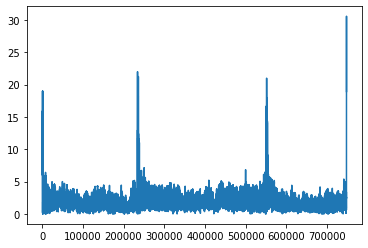

In [15]:
cleanedData.spread.plot()
plt.show()

In [16]:
cleanedData[cleanedData.spread>15]

,utcsec,ex,bid,bidsize,ofr,ofrsize,mode,Date,Timestamp,TSRemainder,Hour,Minute,Ticker,price,spread,hour_min_col,time_group
7,32443664221028,Q,1124.00,7,1139.90,1,R,20200401,2020-04-01 09:00:43.664221,028,9,0,GOOG,1131.950,15.90,9.012129,NaN
9,32450960939439,Q,1124.00,7,1139.90,1,R,20200401,2020-04-01 09:00:50.960939,439,9,0,GOOG,1131.950,15.90,9.014156,NaN
11,32451064948159,Q,1124.00,7,1139.90,1,R,20200401,2020-04-01 09:00:51.064948,159,9,0,GOOG,1131.950,15.90,9.014185,NaN
13,32464838983433,Q,1124.00,7,1139.90,1,R,20200401,2020-04-01 09:01:04.838983,433,9,1,GOOG,1131.950,15.90,9.018011,NaN
15,32464981478455,Q,1124.00,7,1139.90,1,R,20200401,2020-04-01 09:01:04.981478,455,9,1,GOOG,1131.950,15.90,9.018050,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748238,59014429243416,Q,1081.81,1,1102.00,1,R,20200403,2020-04-03 16:23:34.429243,416,16,23,GOOG,1091.905,20.19,16.392897,NaN
748239,59189385562334,Q,1081.81,1,1098.00,1,R,20200403,2020-04-03 16:26:29.385562,334,16,26,GOOG,1089.905,16.19,16.441496,NaN
748240,59189415558284,Q,1081.81,1,1100.66,1,R,20200403,2020-04-03 16:26:29.415558,284,16,26,GOOG,1091.235,18.85,16.441504,NaN
748241,59189419915779,Q,1081.81,1,1102.00,1,R,20200403,2020-04-03 16:26:29.419915,779,16,26,GOOG,1091.905,20.19,16.441506,NaN


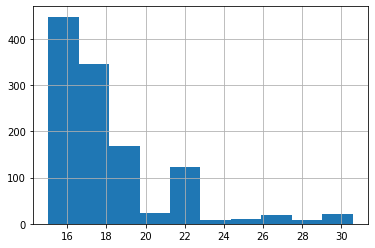

In [19]:
cleanedData[cleanedData.spread>15].spread.hist()
plt.show()

In [20]:
cleanedData.spread.median()

1.8799999999998818

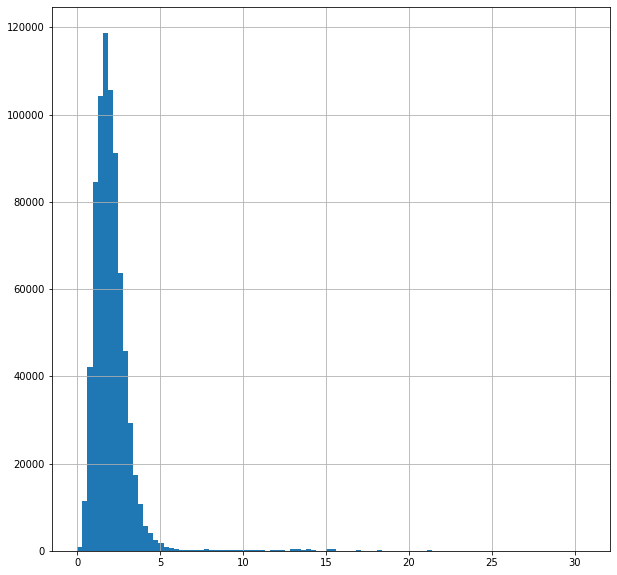

In [22]:
plt.figure(figsize=(10,10))
cleanedData.spread.hist(bins = 100)
plt.show()